### 1. Загрузите датасет артефактов вредоносного ПО, хранящихся в памяти - [cybersecurity.csv](cybersequrity.csv)

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns

def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

D:\setup\anaconda\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


### 2. Подготовьте данные к обучению - **1 балл**
    - Разделите датасет на обучающую, валидационную и тестовую выборки со стратификацией в пропорции 60/20/20. В качестве целевой переменной используйте столбец `Class` - бинарный столбец (0 - нейтральное ПО, 1 - вредоносное ПО).
    - **hint**: для ускорения сходимости и стабилизации обучения можно стандартизировать входные признаки, например, с помощью `StandardScaler`
    - Создайте объекты для работы с данными в PyTorch - `Dataset` и `DataLoader` для обучающей, валидационной и тестовой выборок. Выберите оптимальный, на ваш взгляд, `batch_size`.

In [2]:
# Установка случайного состояния
set_seed(42)

# Загрузка данных
df = pd.read_csv('cybersequrity.csv')

# Разделение на признаки и целевую переменную
X = df.drop('Class', axis=1)
y = df['Class']

# Первое разделение: отделяем 20% для тестовой выборки
X_temp, X_test, y_temp, y_test = train_test_split(X, y, 
                                                 test_size=0.2, 
                                                 stratify=y, 
                                                 random_state=42)

# Второе разделение: делим оставшиеся 80% в пропорции 75%/25% (что даст 60%/20% от исходного размера)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, 
                                                 test_size=0.25,  # 0.25 от 80% = 20% от исходного
                                                 stratify=y_temp, 
                                                 random_state=41)

# Проверка пропорций
print(f"Training set size: {len(X_train)} ({len(X_train)/len(X)*100:.1f}%)")
print(f"Validation set size: {len(X_val)} ({len(X_val)/len(X)*100:.1f}%)")
print(f"Test set size: {len(X_test)} ({len(X_test)/len(X)*100:.1f}%)")

# Стандартизация данных
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

Training set size: 6000 (60.0%)
Validation set size: 2000 (20.0%)
Test set size: 2000 (20.0%)


In [3]:
class CyberSecurityDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.FloatTensor(y.values)
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Создание датасетов
train_dataset = CyberSecurityDataset(X_train_scaled, y_train)
val_dataset = CyberSecurityDataset(X_val_scaled, y_val)
test_dataset = CyberSecurityDataset(X_test_scaled, y_test)

# Создание даталоадеров
# Batch size 64 выбран как оптимальный компромисс между скоростью обучения и памятью
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

### 3. Реализуйте класс бейзлайновой нейросетевой модели (MLP) для решения задачи - **2 балла**
    - Определите оптимальное количество `Linear` слоев в структуре и их размерности.
    - Подберите оптимальные для задачи функции активации - `ReLU`, `Sigmoid`, `Tanh`, `LeakyReLU`...
    - Реализуйте логику прохождения данных по сети в методе `forward`
    - Cоздайте объект модели, реализуйте перевод модели на gpu

In [4]:
class BaselineMLP(nn.Module):
    def __init__(self, input_size):
        super(BaselineMLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, 32),  # только один скрытый слой
            nn.ReLU(),  # простейшая и самая базовая функция активации
            nn.Linear(32, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        return self.layers(x)

# Создание модели
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = BaselineMLP(input_size=X_train.shape[1]).to(device)

Обоснование архитектуры:

1. Количество слоев:

- Выбрано 2 слоя (1 скрытый + 1 выходной) как базовый вариант
- Минимальная конфигурация, способная выучить нелинейные зависимости
- Максимально простая архитектура для базовой модели
- Быстрая сходимость и низкий риск переобучения


2. Размеры слоев:

- Один скрытый слой размерности 32 для начального преобразования признаков
- Размерность 32 выбрана как степень двойки для эффективных вычислений
- Размер достаточно мал, чтобы избежать излишней сложности
- Выходной слой размерности 1 для бинарной классификации


3. Активации:

- ReLU выбран для скрытого слоя как самый базовый и простой вариант
- Легкость в обучении и интерпретации
- Отсутствие проблемы затухающих градиентов
- Sigmoid на выходном слое для получения вероятностей в диапазоне [0,1]


4. Простота архитектуры:

- Отсутствие дополнительных слоев и механизмов
- Минимум гиперпараметров для настройки
- Базовая версия для последующих улучшений
- Легкость в анализе и отладке

### 4. Напишите код цикла обучения - train-loop и валидации - eval-loop. В процессе обучения сохраняйте и визуализируйте на графике динамику функции потерь на тренировочной и валидационной выборках - **1 балл**

In [5]:
def train_loop(model, train_loader, criterion, optimizer):
    model.train()
    total_loss = 0
    for X, y in train_loader:
        X, y = X.to(device), y.to(device)
        
        optimizer.zero_grad()
        output = model(X).squeeze()
        loss = criterion(output, y)
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    return total_loss / len(train_loader)

def eval_loop(model, val_loader, criterion):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for X, y in val_loader:
            X, y = X.to(device), y.to(device)
            output = model(X).squeeze()
            loss = criterion(output, y)
            total_loss += loss.item()
    
    return total_loss / len(val_loader)

### 5. Обучите модель и проверьте ее качество - **1 балл**
    - Выберите оптимизатор, в качестве функции потерь используйте `nn.BCELoss`
    - Запустите обучение, постарайтесь подобрать оптимальные скорость обучения и количество эпох, ориентируясь на динамику функции потерь на train/val
    - Измерьте качество лучшей модели на тестовой выборке, постройте отчет о классификации - `classification_report`

Epoch 10/100:
Training Loss: 0.4664
Validation Loss: 0.5640
Epoch 20/100:
Training Loss: 0.4658
Validation Loss: 0.5628
Epoch 30/100:
Training Loss: 0.4629
Validation Loss: 0.5572
Epoch 40/100:
Training Loss: 0.4611
Validation Loss: 0.5568
Epoch 50/100:
Training Loss: 0.4583
Validation Loss: 0.5107
Epoch 60/100:
Training Loss: 0.4567
Validation Loss: 0.5509
Epoch 70/100:
Training Loss: 0.4538
Validation Loss: 0.5113
Epoch 80/100:
Training Loss: 0.4555
Validation Loss: 0.5054
Epoch 90/100:
Training Loss: 0.4507
Validation Loss: 0.5480
Epoch 100/100:
Training Loss: 0.4493
Validation Loss: 0.5456


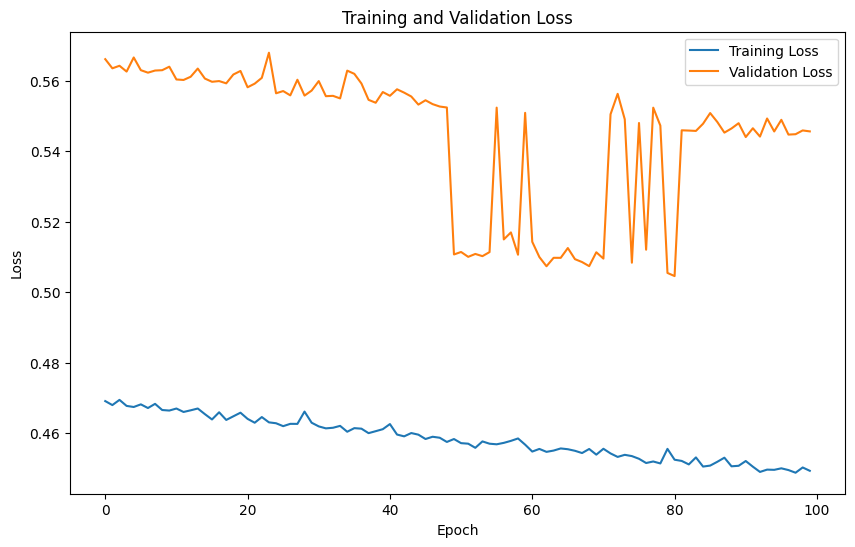


Test Set Performance:
              precision    recall  f1-score   support

         0.0       0.77      0.80      0.78       981
         1.0       0.80      0.77      0.78      1019

    accuracy                           0.78      2000
   macro avg       0.78      0.78      0.78      2000
weighted avg       0.79      0.78      0.78      2000



In [7]:
def evaluate_model(model, test_loader):
    model.eval()
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for X, y in test_loader:
            X, y = X.to(device), y.to(device)
            outputs = model(X).squeeze()
            preds = (outputs >= 0.5).float()
            
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(y.cpu().numpy())
    
    return classification_report(all_targets, all_preds)

# Настройка обучения
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
n_epochs = 100

# Списки для хранения истории обучения
train_losses = []
val_losses = []
best_val_loss = float('inf')
best_model_state = None

# Цикл обучения
for epoch in range(n_epochs):
    train_loss = train_loop(model, train_loader, criterion, optimizer)
    val_loss = eval_loop(model, val_loader, criterion)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    # Сохраняем лучшую модель по validation loss
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = model.state_dict().copy()
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch {epoch+1}/{n_epochs}:')
        print(f'Training Loss: {train_loss:.4f}')
        print(f'Validation Loss: {val_loss:.4f}')

# Загружаем лучшую модель
model.load_state_dict(best_model_state)

# Визуализация процесса обучения
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Оценка модели на тестовой выборке
print("\nTest Set Performance:")
print(evaluate_model(model, test_loader))

Обоснование выбора параметров обучения модели

1. Функция потерь (Loss Function)
- Выбрана `nn.BCELoss()` (Binary Cross Entropy Loss):
 - Оптимальна для задач бинарной классификации
 - Хорошо работает в паре с sigmoid-активацией на выходном слое
 - Позволяет оценивать расхождение между предсказанными вероятностями и истинными метками классов

2. Оптимизатор
- Выбран `Adam` оптимизатор по следующим причинам:
 - Адаптивная настройка learning rate для каждого параметра
 - Хорошая сходимость в большинстве задач
 - Устойчивость к выбору learning rate
 - Эффективная работа с разреженными градиентами
 - Learning rate = 0.001 - стандартное значение для Adam, обеспечивающее баланс между скоростью сходимости и стабильностью

3. Количество эпох и мониторинг обучения
- Выбрано 100 эпох исходя из:
 - Достаточно для сходимости в большинстве задач подобной сложности
 - Позволяет отследить возможное переобучение
- Реализовано сохранение лучшей модели:
 - Отслеживание validation loss
 - Сохранение состояния модели при улучшении метрики
 - Защита от переобучения

Получилось достаточно неплохое качество для такой простой архитектуры.

### 6. Улучшите архитектуру модели из пункта 3 и добейтесь увеличения качества - **3 балла**
    - Попробуйте добавить слои `BatchNorm1d` и `Dropout` - поэкспериментируйте с их "расположением" в сети, напишите свои выводы о целесообразности их добавления в модель, оптимальном расположении, влиянии на качество/сходимость обучения. При использовании слоя `Dropout` - определите экспериментально или обоснуйте теоретически оптимальное значение параметра `p`.
    - Обучите улучшенную модель и проверьте ее качество (при необходимости измените гиперпараметры обучения - `batch_size`, скорость обучения и количество эпох, ориентируясь на динамику функции потерь на train/val и архитектуру модели)

#### 6.1 Усложнение архитектуры модели: увеличение слоев, Dropout и BatchNorm1d


Experiment with dropout_rate=0.1, batch_size=32, lr=0.001
Epoch 10/100:
Training Loss: 0.4831
Validation Loss: 0.5884
Epoch 20/100:
Training Loss: 0.4634
Validation Loss: 0.5833
Early stopping at epoch 21


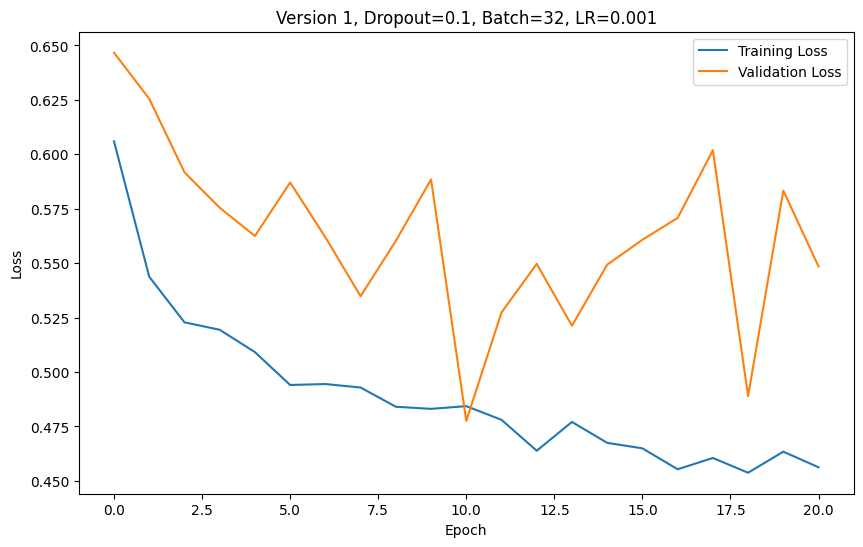

Epoch 10/100:
Training Loss: 0.4497
Validation Loss: 0.5745
Early stopping at epoch 14


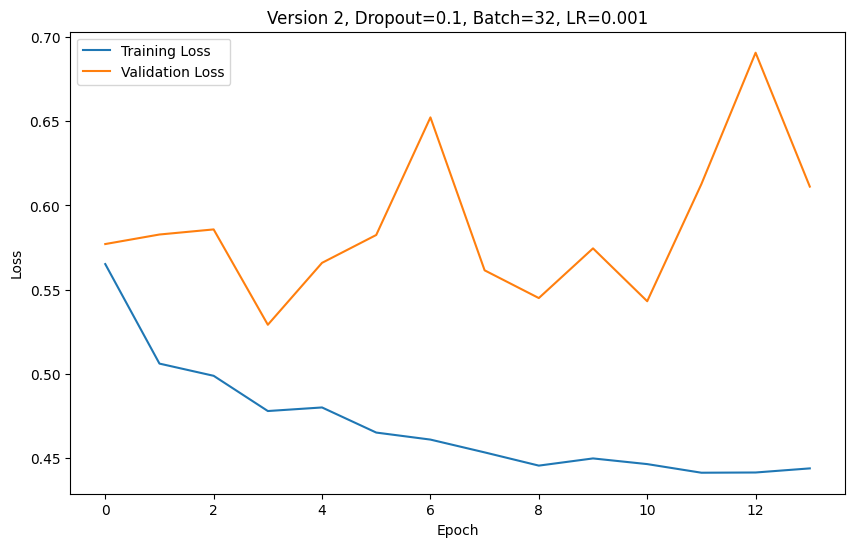


Experiment with dropout_rate=0.1, batch_size=32, lr=0.0005
Epoch 10/100:
Training Loss: 0.4727
Validation Loss: 0.5997
Early stopping at epoch 15


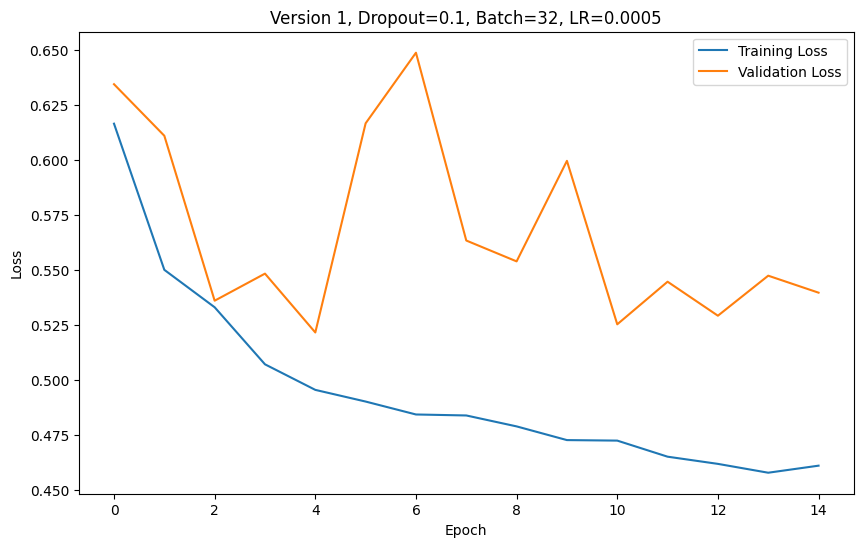

Epoch 10/100:
Training Loss: 0.4375
Validation Loss: 0.4876
Epoch 20/100:
Training Loss: 0.4117
Validation Loss: 0.5628
Early stopping at epoch 24


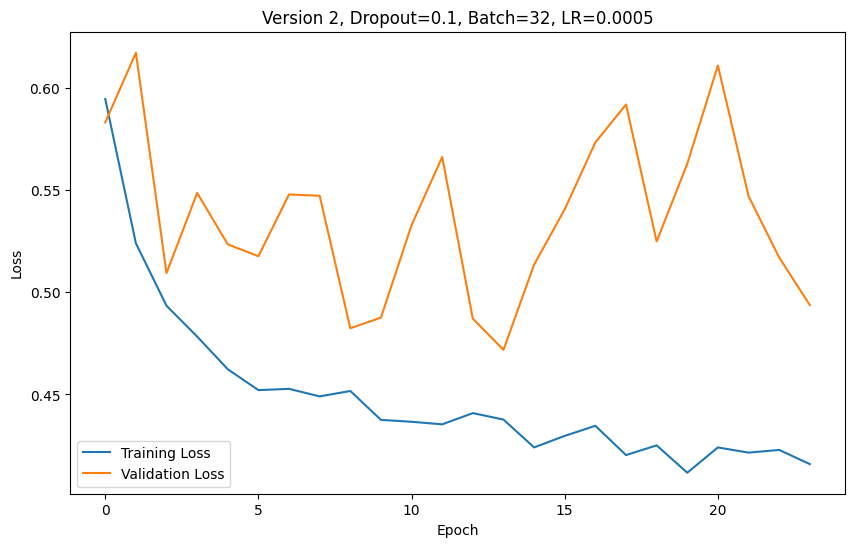


Experiment with dropout_rate=0.1, batch_size=64, lr=0.001
Epoch 10/100:
Training Loss: 0.4534
Validation Loss: 0.5979
Epoch 20/100:
Training Loss: 0.4342
Validation Loss: 0.5076
Early stopping at epoch 25


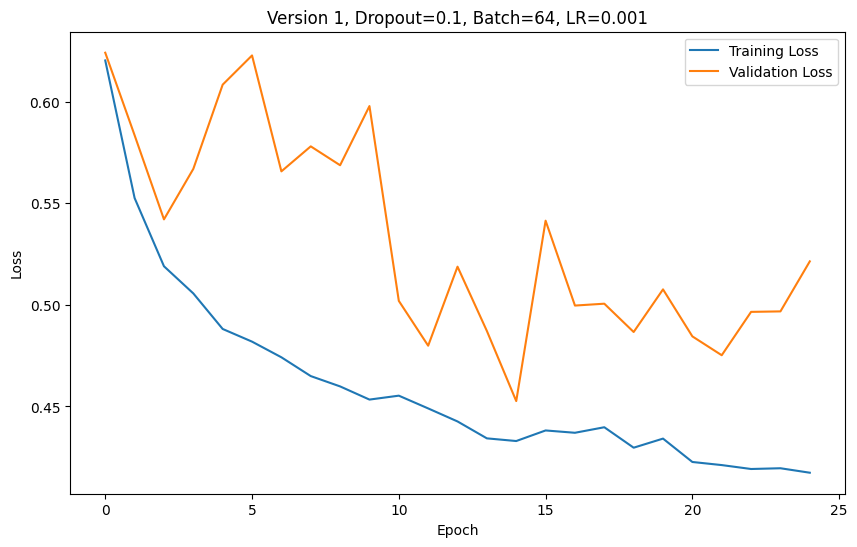

Epoch 10/100:
Training Loss: 0.4301
Validation Loss: 0.5527
Epoch 20/100:
Training Loss: 0.4042
Validation Loss: 0.4771
Epoch 30/100:
Training Loss: 0.3812
Validation Loss: 0.4419
Epoch 40/100:
Training Loss: 0.3869
Validation Loss: 0.4088
Early stopping at epoch 48


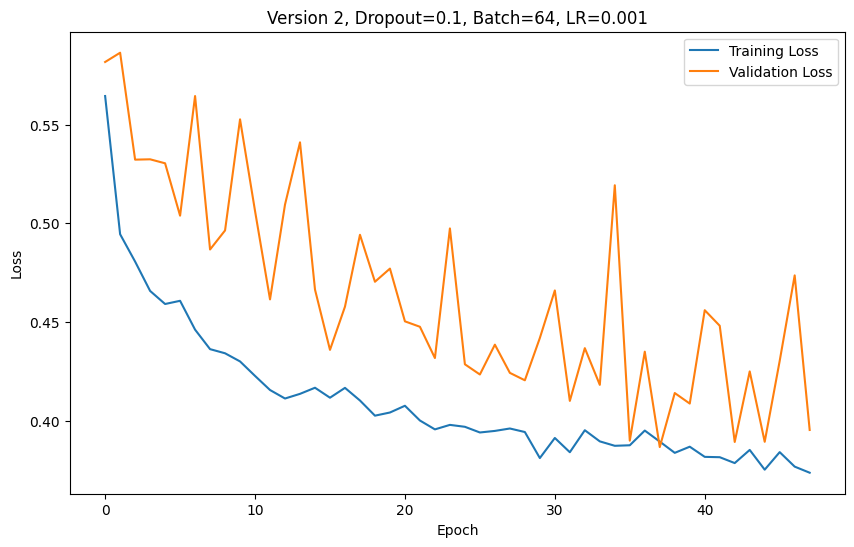


Experiment with dropout_rate=0.1, batch_size=64, lr=0.0005
Epoch 10/100:
Training Loss: 0.4697
Validation Loss: 0.5626
Early stopping at epoch 15


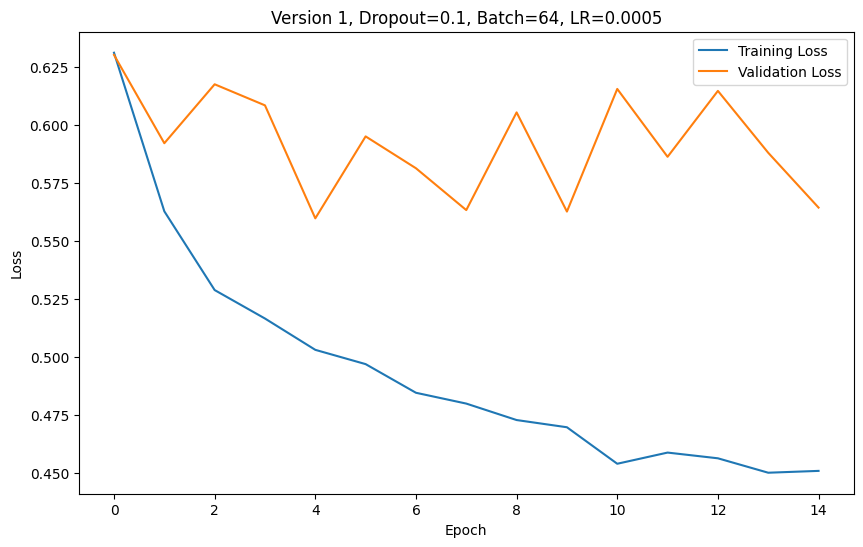

Epoch 10/100:
Training Loss: 0.4371
Validation Loss: 0.5349
Early stopping at epoch 19


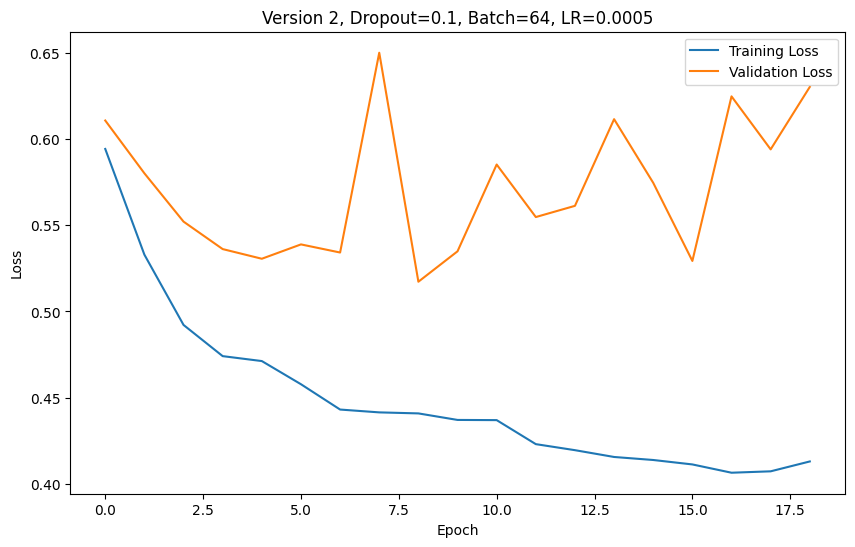


Experiment with dropout_rate=0.1, batch_size=128, lr=0.001
Epoch 10/100:
Training Loss: 0.4573
Validation Loss: 0.4693
Epoch 20/100:
Training Loss: 0.4165
Validation Loss: 0.4739
Epoch 30/100:
Training Loss: 0.4008
Validation Loss: 0.4205
Epoch 40/100:
Training Loss: 0.3941
Validation Loss: 0.4098
Early stopping at epoch 45


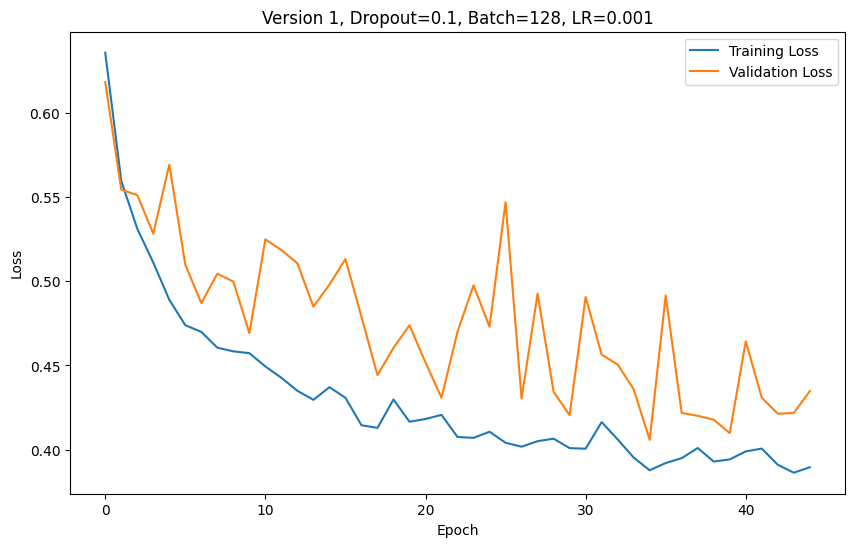

Epoch 10/100:
Training Loss: 0.4265
Validation Loss: 0.5508
Early stopping at epoch 15


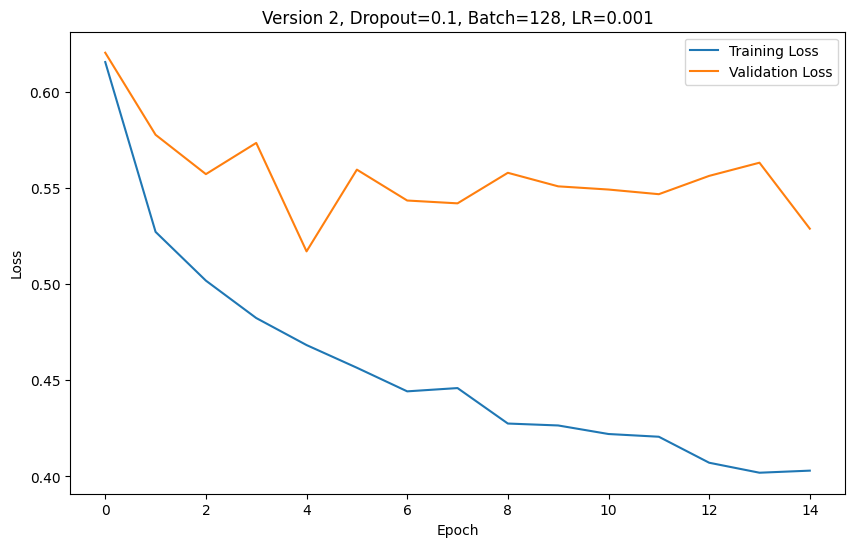


Experiment with dropout_rate=0.1, batch_size=128, lr=0.0005
Epoch 10/100:
Training Loss: 0.4770
Validation Loss: 0.5258
Epoch 20/100:
Training Loss: 0.4286
Validation Loss: 0.4929
Epoch 30/100:
Training Loss: 0.4145
Validation Loss: 0.4710
Early stopping at epoch 37


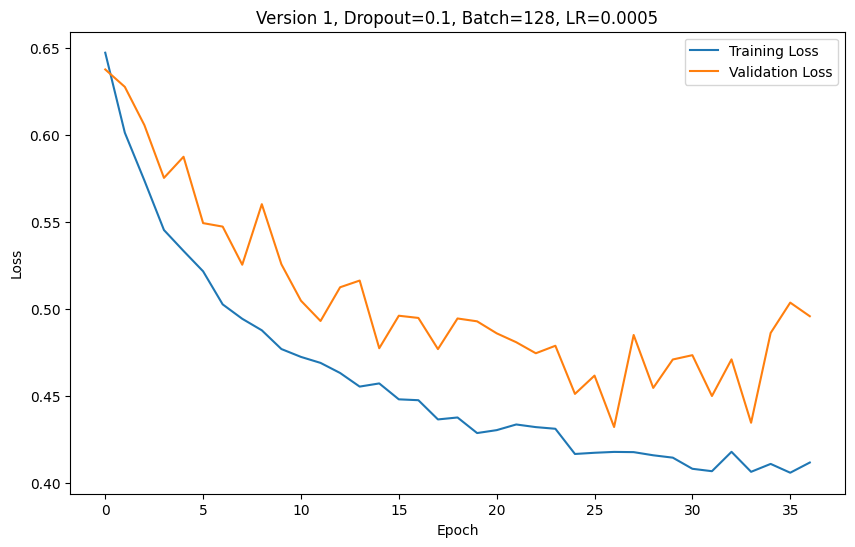

Epoch 10/100:
Training Loss: 0.4308
Validation Loss: 0.4985
Epoch 20/100:
Training Loss: 0.4065
Validation Loss: 0.4350
Epoch 30/100:
Training Loss: 0.3913
Validation Loss: 0.4072
Epoch 40/100:
Training Loss: 0.3832
Validation Loss: 0.4062
Epoch 50/100:
Training Loss: 0.3666
Validation Loss: 0.3801
Epoch 60/100:
Training Loss: 0.3581
Validation Loss: 0.3913
Epoch 70/100:
Training Loss: 0.3580
Validation Loss: 0.3900
Early stopping at epoch 71


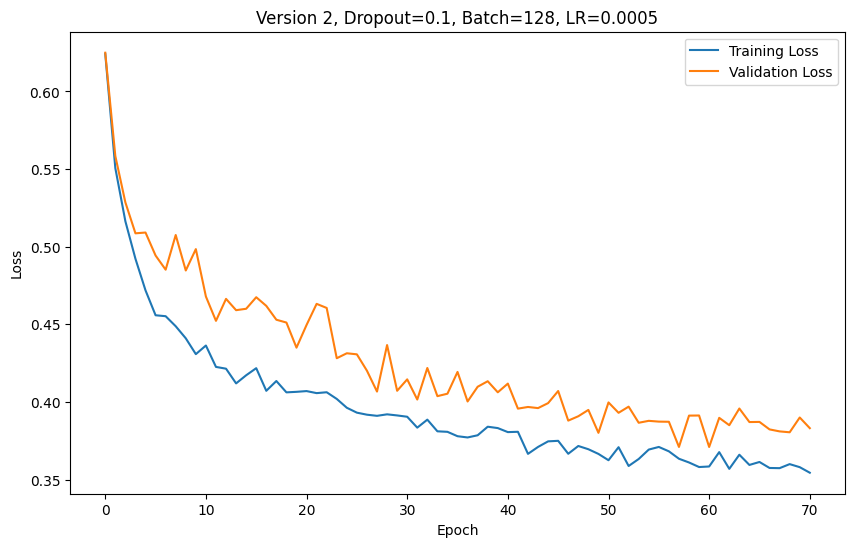


Experiment with dropout_rate=0.2, batch_size=32, lr=0.001
Epoch 10/100:
Training Loss: 0.4848
Validation Loss: 0.5937
Epoch 20/100:
Training Loss: 0.4707
Validation Loss: 0.4950
Early stopping at epoch 24


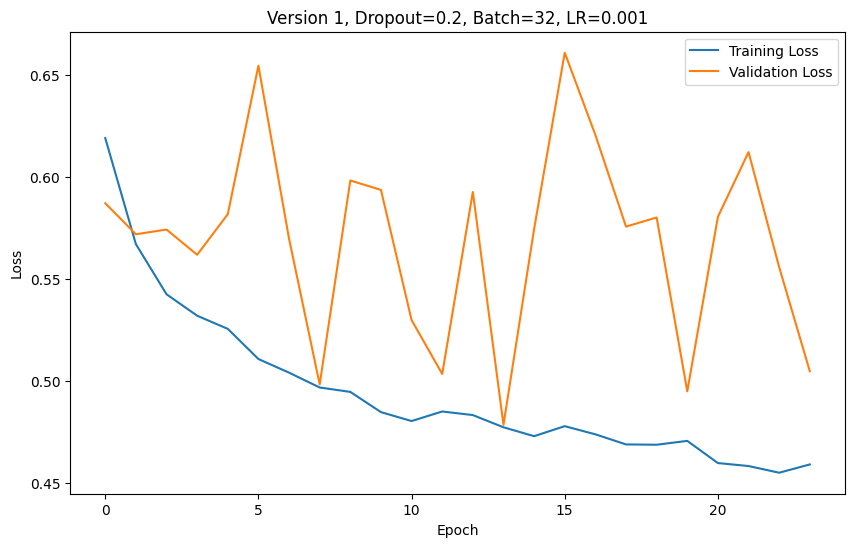

Epoch 10/100:
Training Loss: 0.4686
Validation Loss: 0.5958
Early stopping at epoch 18


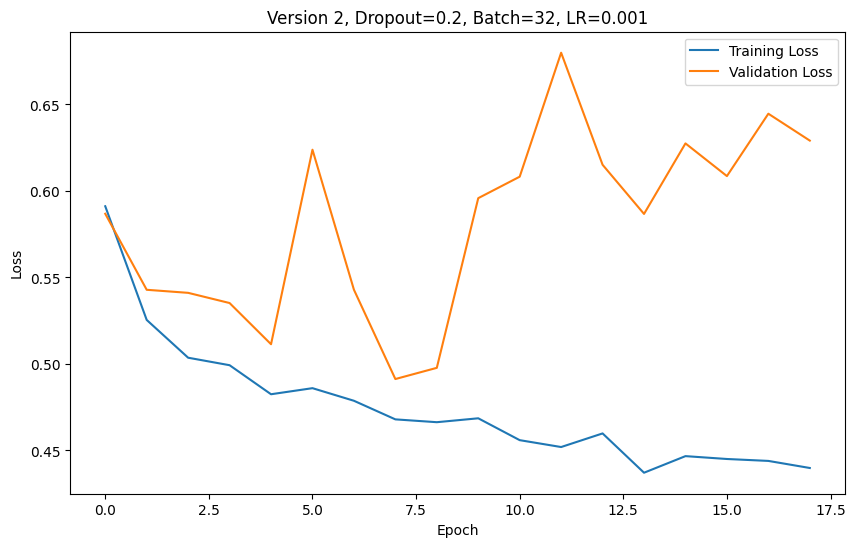


Experiment with dropout_rate=0.2, batch_size=32, lr=0.0005
Epoch 10/100:
Training Loss: 0.4905
Validation Loss: 0.5613
Epoch 20/100:
Training Loss: 0.4653
Validation Loss: 0.5534
Early stopping at epoch 26


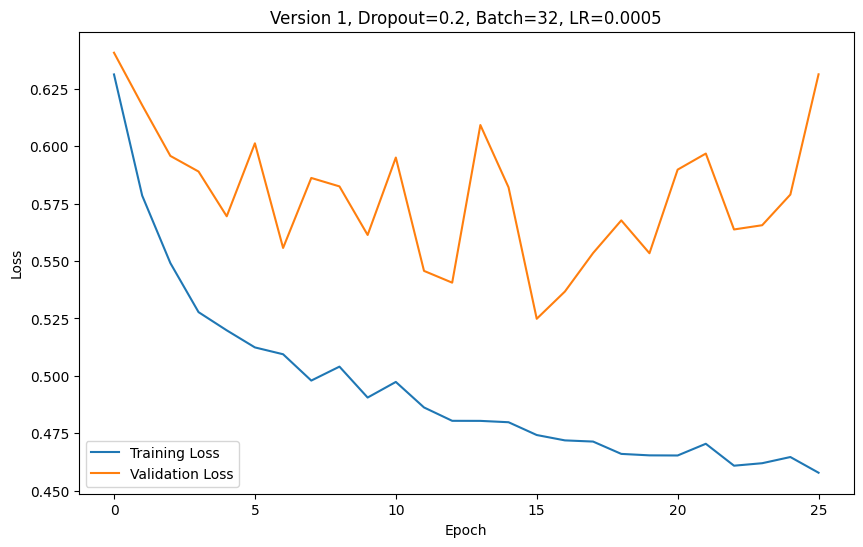

Epoch 10/100:
Training Loss: 0.4782
Validation Loss: 0.5298
Early stopping at epoch 17


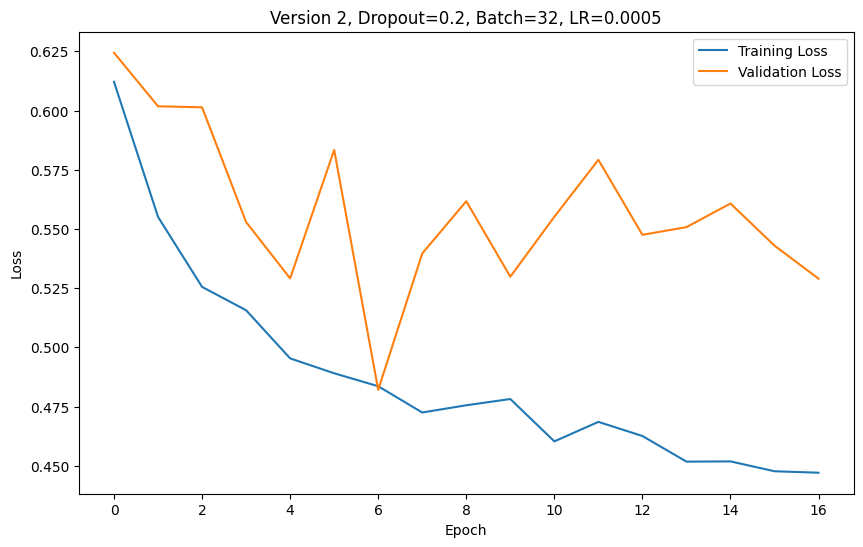


Experiment with dropout_rate=0.2, batch_size=64, lr=0.001
Epoch 10/100:
Training Loss: 0.4773
Validation Loss: 0.5369
Epoch 20/100:
Training Loss: 0.4438
Validation Loss: 0.5247
Early stopping at epoch 29


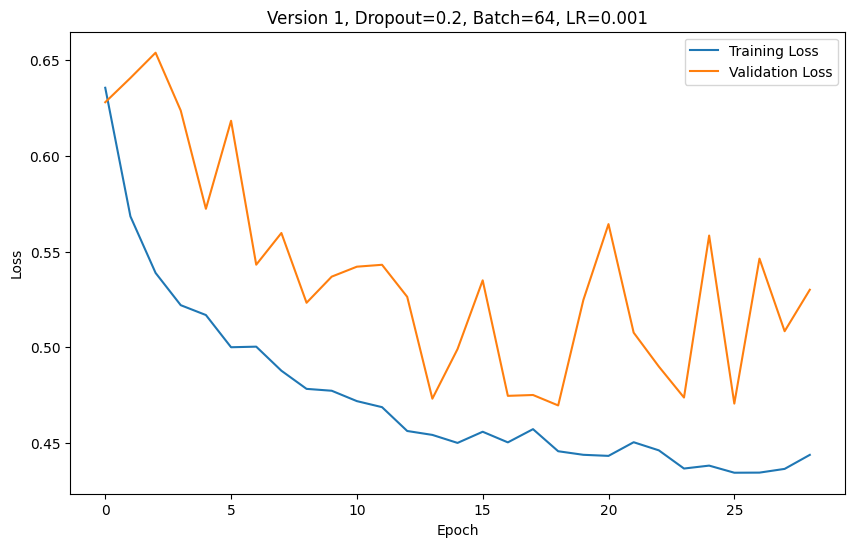

Epoch 10/100:
Training Loss: 0.4410
Validation Loss: 0.5232
Epoch 20/100:
Training Loss: 0.4284
Validation Loss: 0.5394
Epoch 30/100:
Training Loss: 0.4212
Validation Loss: 0.4409
Epoch 40/100:
Training Loss: 0.4094
Validation Loss: 0.4944
Early stopping at epoch 42


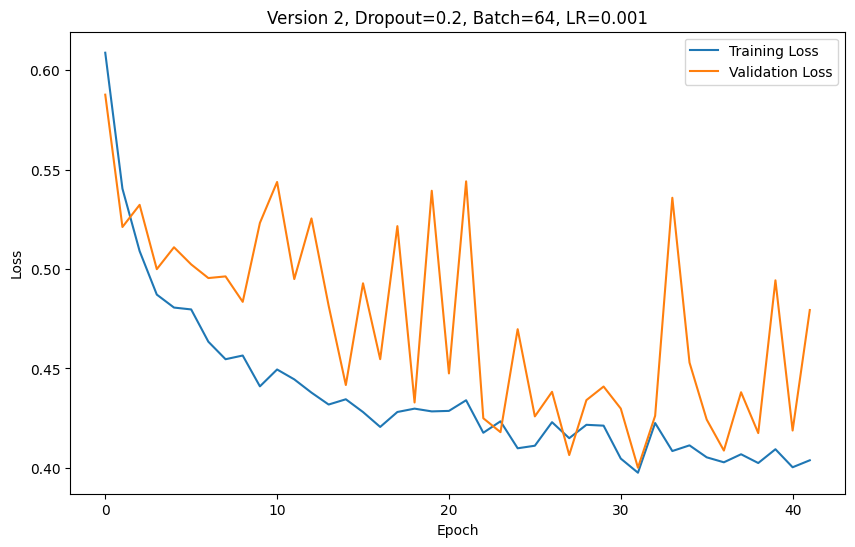


Experiment with dropout_rate=0.2, batch_size=64, lr=0.0005
Epoch 10/100:
Training Loss: 0.4884
Validation Loss: 0.5660
Epoch 20/100:
Training Loss: 0.4436
Validation Loss: 0.4953
Early stopping at epoch 30


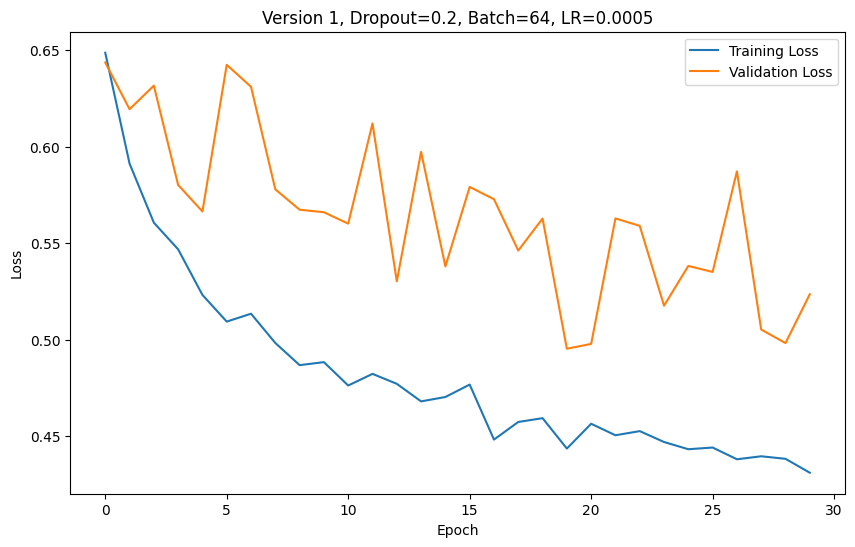

Epoch 10/100:
Training Loss: 0.4432
Validation Loss: 0.5188
Early stopping at epoch 19


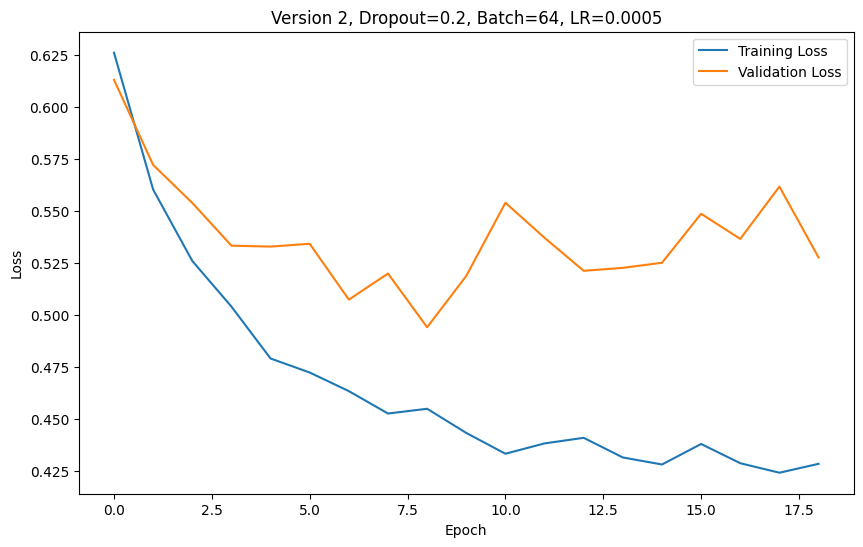


Experiment with dropout_rate=0.2, batch_size=128, lr=0.001
Epoch 10/100:
Training Loss: 0.4715
Validation Loss: 0.5297
Epoch 20/100:
Training Loss: 0.4312
Validation Loss: 0.4857
Epoch 30/100:
Training Loss: 0.4149
Validation Loss: 0.4407
Epoch 40/100:
Training Loss: 0.4088
Validation Loss: 0.4732
Epoch 50/100:
Training Loss: 0.4101
Validation Loss: 0.4827
Epoch 60/100:
Training Loss: 0.3957
Validation Loss: 0.3943
Epoch 70/100:
Training Loss: 0.3930
Validation Loss: 0.4831
Early stopping at epoch 75


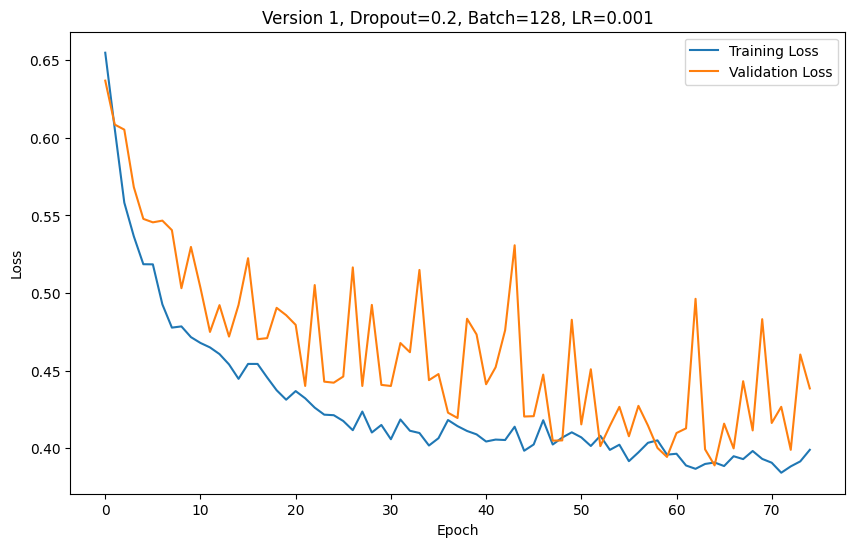

Epoch 10/100:
Training Loss: 0.4461
Validation Loss: 0.4947
Epoch 20/100:
Training Loss: 0.4042
Validation Loss: 0.4515
Epoch 30/100:
Training Loss: 0.3957
Validation Loss: 0.4963
Early stopping at epoch 35


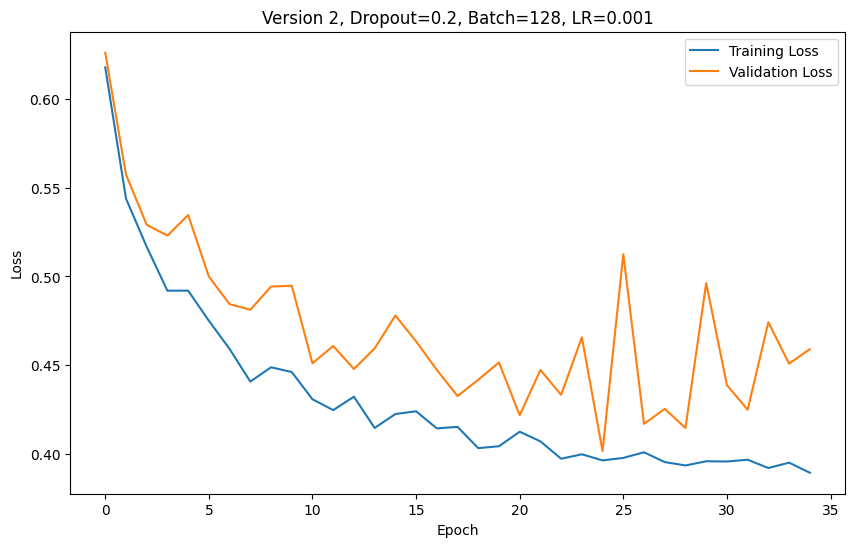


Experiment with dropout_rate=0.2, batch_size=128, lr=0.0005
Epoch 10/100:
Training Loss: 0.4888
Validation Loss: 0.5292
Epoch 20/100:
Training Loss: 0.4508
Validation Loss: 0.4763
Epoch 30/100:
Training Loss: 0.4388
Validation Loss: 0.4621
Epoch 40/100:
Training Loss: 0.4151
Validation Loss: 0.4568
Early stopping at epoch 41


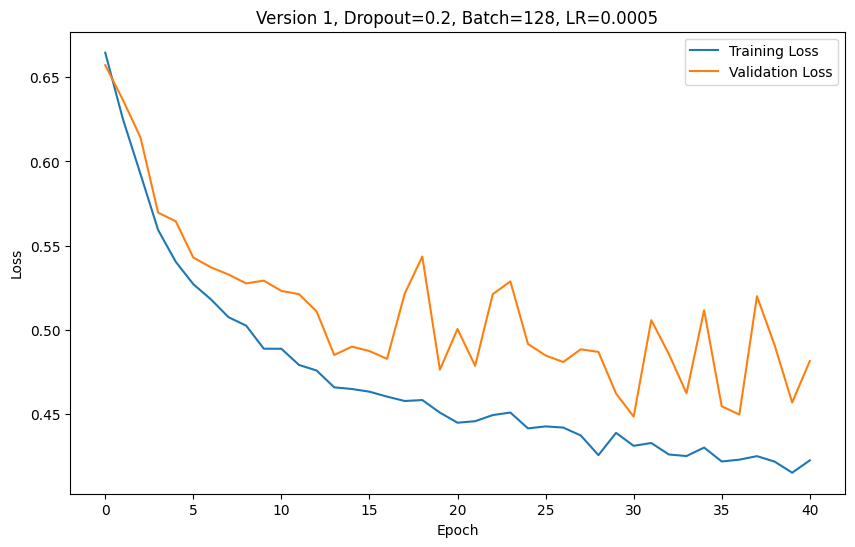

Epoch 10/100:
Training Loss: 0.4625
Validation Loss: 0.5667
Epoch 20/100:
Training Loss: 0.4211
Validation Loss: 0.5275
Epoch 30/100:
Training Loss: 0.4039
Validation Loss: 0.5268
Early stopping at epoch 38


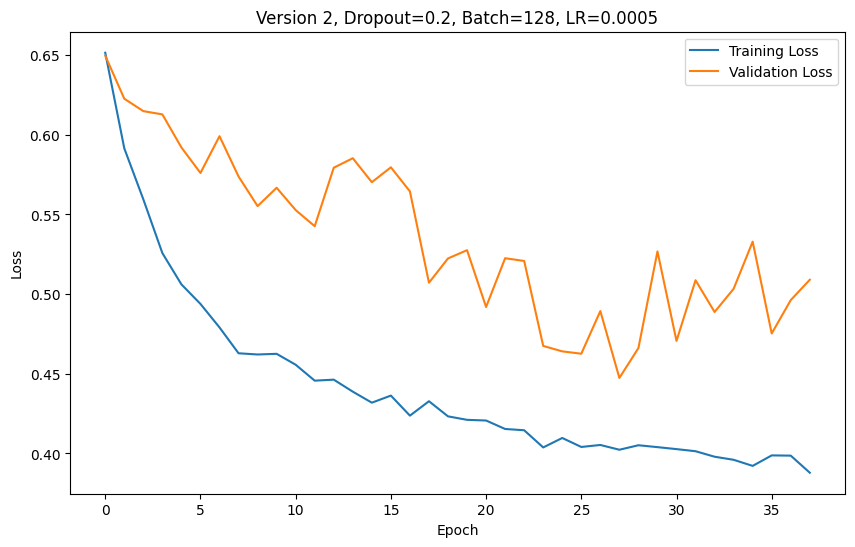


Experiment with dropout_rate=0.3, batch_size=32, lr=0.001
Epoch 10/100:
Training Loss: 0.5061
Validation Loss: 0.5901
Epoch 20/100:
Training Loss: 0.4854
Validation Loss: 0.5873
Early stopping at epoch 25


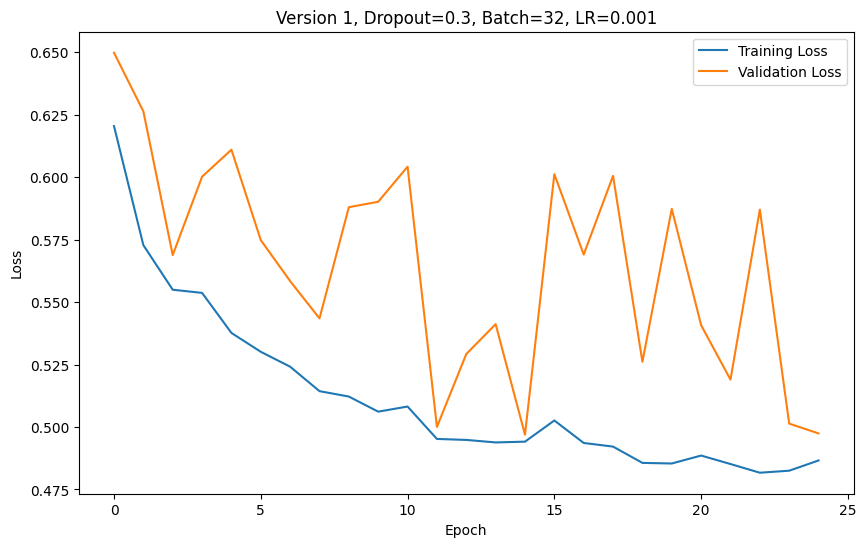

Epoch 10/100:
Training Loss: 0.4811
Validation Loss: 0.5738
Epoch 20/100:
Training Loss: 0.4659
Validation Loss: 0.5221
Epoch 30/100:
Training Loss: 0.4533
Validation Loss: 0.4477
Epoch 40/100:
Training Loss: 0.4444
Validation Loss: 0.5274
Early stopping at epoch 48


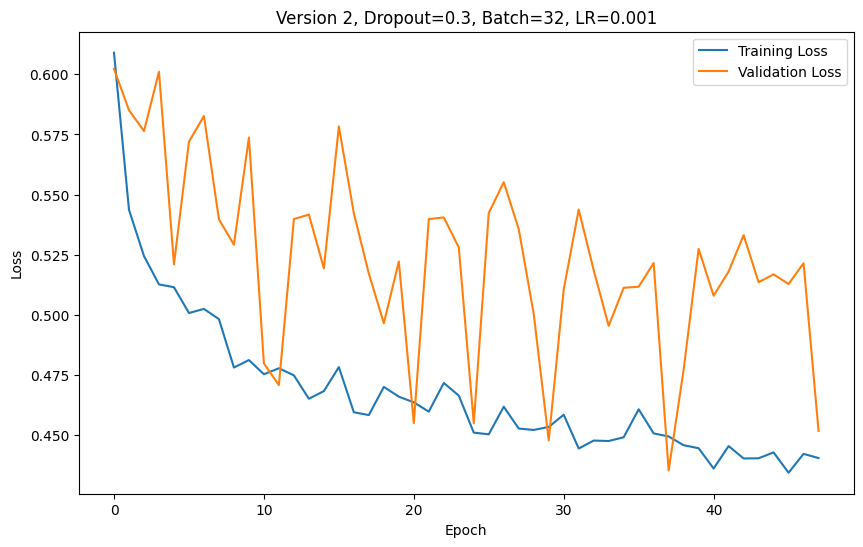


Experiment with dropout_rate=0.3, batch_size=32, lr=0.0005
Epoch 10/100:
Training Loss: 0.5174
Validation Loss: 0.5680
Epoch 20/100:
Training Loss: 0.4871
Validation Loss: 0.5760
Early stopping at epoch 28


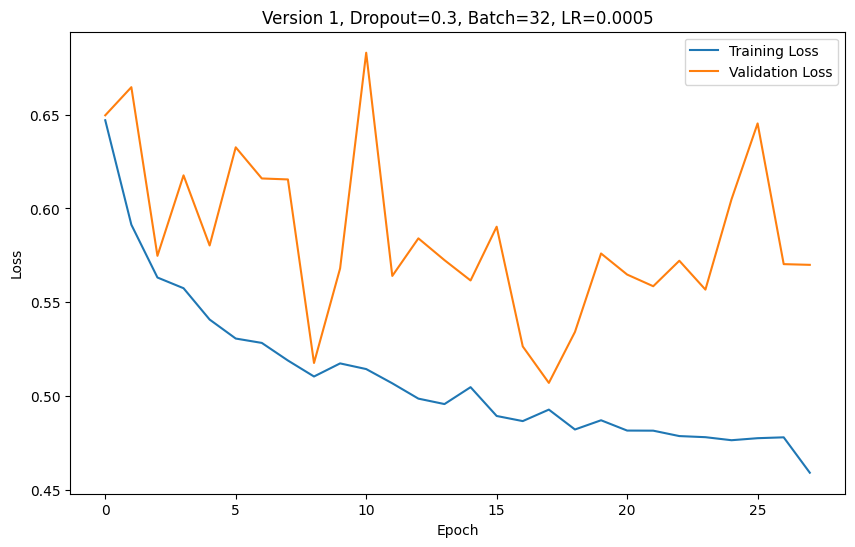

Epoch 10/100:
Training Loss: 0.4915
Validation Loss: 0.5508
Epoch 20/100:
Training Loss: 0.4593
Validation Loss: 0.5679
Epoch 30/100:
Training Loss: 0.4349
Validation Loss: 0.5097
Early stopping at epoch 36


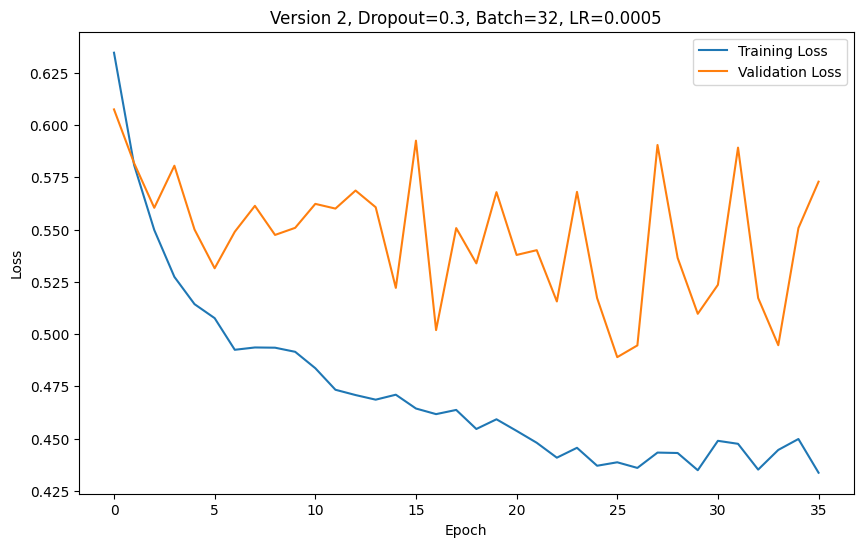


Experiment with dropout_rate=0.3, batch_size=64, lr=0.001
Epoch 10/100:
Training Loss: 0.4997
Validation Loss: 0.5239
Epoch 20/100:
Training Loss: 0.4704
Validation Loss: 0.5246
Early stopping at epoch 23


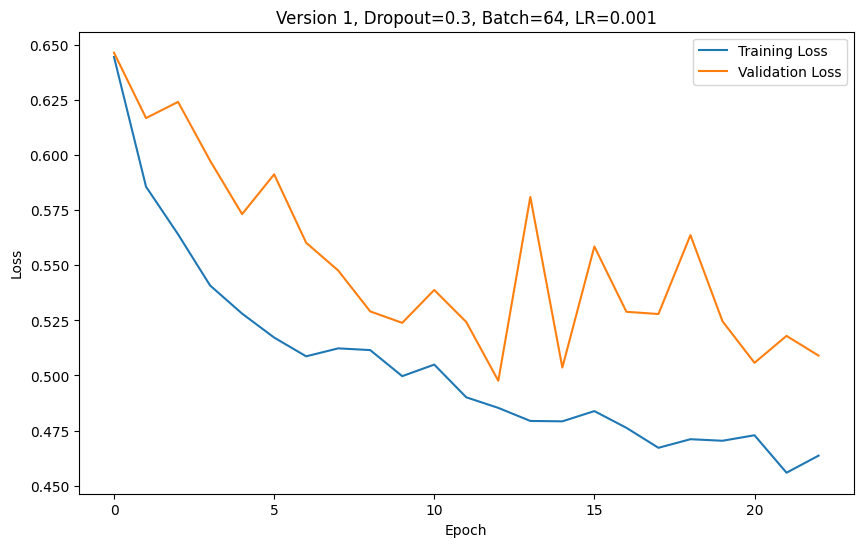

Epoch 10/100:
Training Loss: 0.4598
Validation Loss: 0.5763
Epoch 20/100:
Training Loss: 0.4403
Validation Loss: 0.4413
Epoch 30/100:
Training Loss: 0.4211
Validation Loss: 0.4149
Epoch 40/100:
Training Loss: 0.4127
Validation Loss: 0.4553
Epoch 50/100:
Training Loss: 0.4095
Validation Loss: 0.4430
Epoch 60/100:
Training Loss: 0.4011
Validation Loss: 0.4614
Early stopping at epoch 63


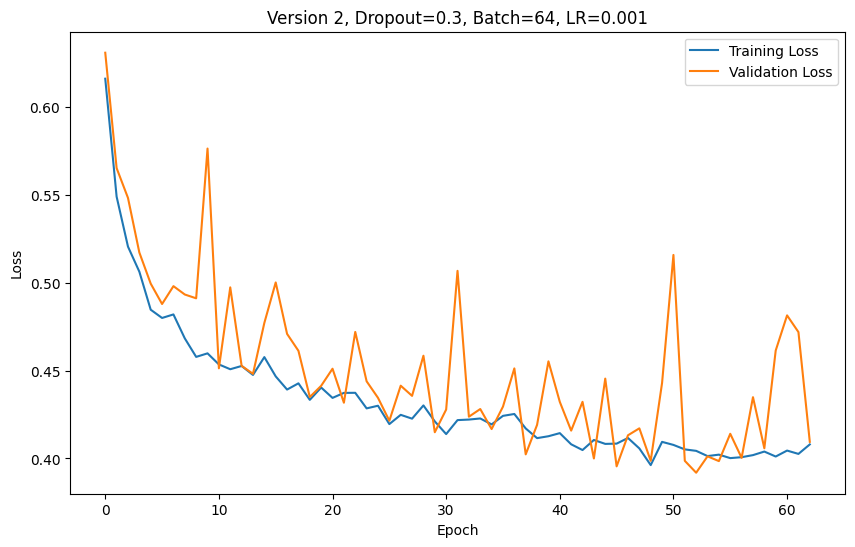


Experiment with dropout_rate=0.3, batch_size=64, lr=0.0005
Epoch 10/100:
Training Loss: 0.5042
Validation Loss: 0.5948
Epoch 20/100:
Training Loss: 0.4749
Validation Loss: 0.5135
Early stopping at epoch 25


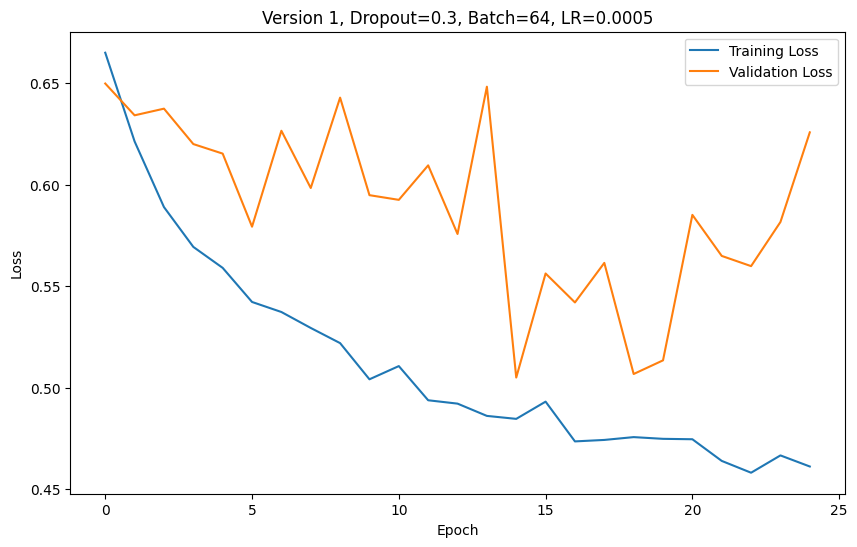

Epoch 10/100:
Training Loss: 0.4594
Validation Loss: 0.6040
Early stopping at epoch 17


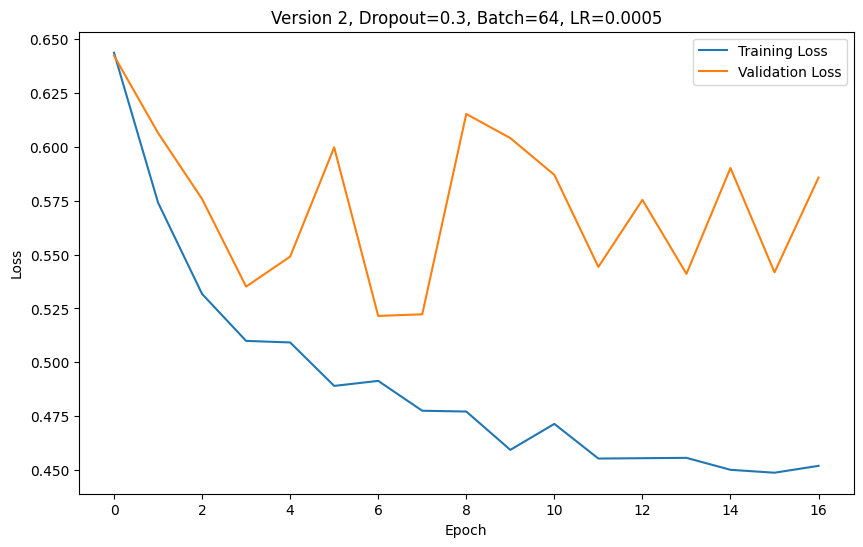


Experiment with dropout_rate=0.3, batch_size=128, lr=0.001
Epoch 10/100:
Training Loss: 0.5059
Validation Loss: 0.5331
Epoch 20/100:
Training Loss: 0.4639
Validation Loss: 0.4924
Epoch 30/100:
Training Loss: 0.4412
Validation Loss: 0.4644
Epoch 40/100:
Training Loss: 0.4240
Validation Loss: 0.4668
Epoch 50/100:
Training Loss: 0.4169
Validation Loss: 0.4359
Early stopping at epoch 59


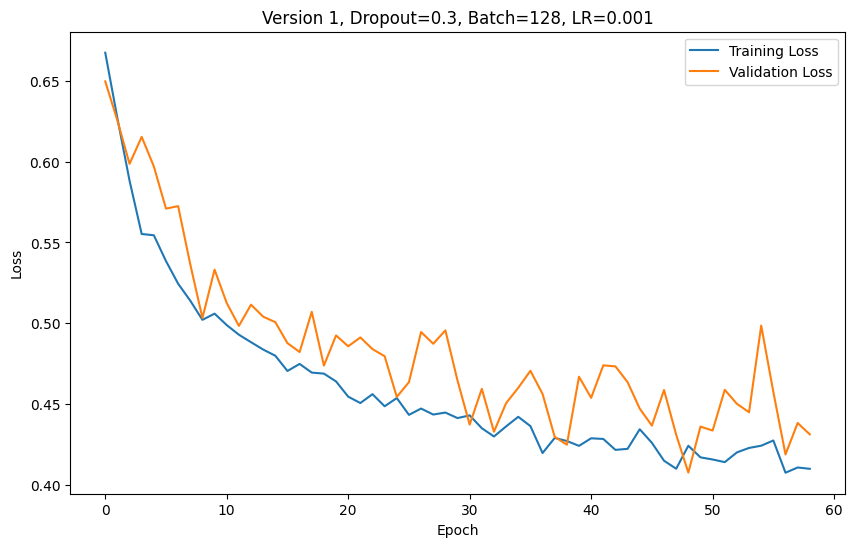

Epoch 10/100:
Training Loss: 0.4385
Validation Loss: 0.4687
Epoch 20/100:
Training Loss: 0.4117
Validation Loss: 0.4266
Epoch 30/100:
Training Loss: 0.4098
Validation Loss: 0.4384
Epoch 40/100:
Training Loss: 0.3930
Validation Loss: 0.4096
Epoch 50/100:
Training Loss: 0.3924
Validation Loss: 0.4006
Epoch 60/100:
Training Loss: 0.3959
Validation Loss: 0.4021
Early stopping at epoch 66


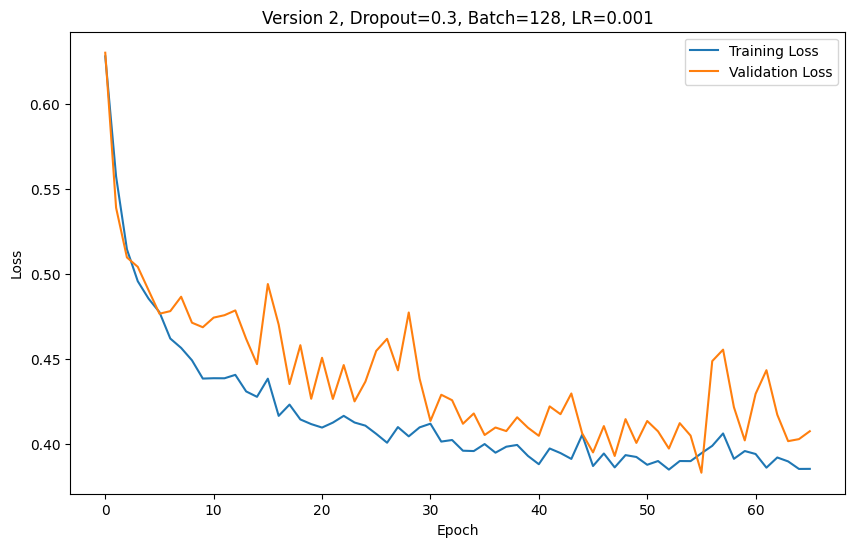


Experiment with dropout_rate=0.3, batch_size=128, lr=0.0005
Epoch 10/100:
Training Loss: 0.5064
Validation Loss: 0.5699
Epoch 20/100:
Training Loss: 0.4629
Validation Loss: 0.4972
Epoch 30/100:
Training Loss: 0.4510
Validation Loss: 0.4875
Early stopping at epoch 35


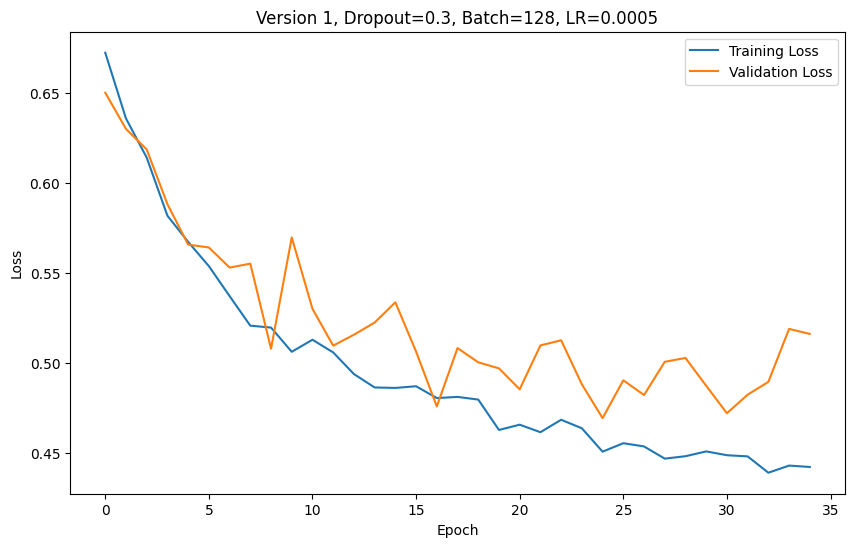

Epoch 10/100:
Training Loss: 0.4905
Validation Loss: 0.5686
Epoch 20/100:
Training Loss: 0.4441
Validation Loss: 0.4714
Epoch 30/100:
Training Loss: 0.4256
Validation Loss: 0.4492
Epoch 40/100:
Training Loss: 0.4225
Validation Loss: 0.4520
Epoch 50/100:
Training Loss: 0.3986
Validation Loss: 0.4422
Early stopping at epoch 59


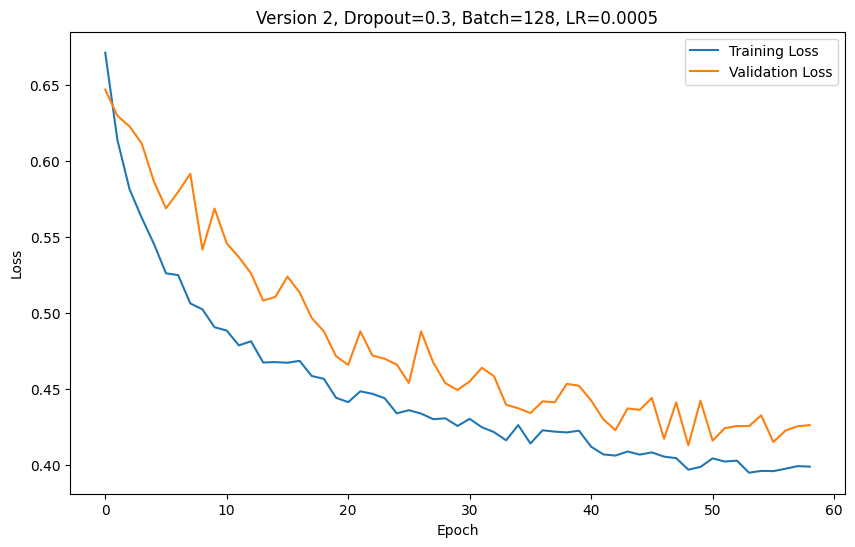

In [8]:
# Определим несколько вариантов архитектуры для экспериментов
class ImprovedMLP_V1(nn.Module):
    def __init__(self, input_size, dropout_rate=0.2):
        super(ImprovedMLP_V1, self).__init__()
        self.layers = nn.Sequential(
            # Добавляем BatchNorm после Linear слоев до активации
            nn.Linear(input_size, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            
            nn.Linear(32, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.layers(x)

class ImprovedMLP_V2(nn.Module):
    def __init__(self, input_size, dropout_rate=0.2):
        super(ImprovedMLP_V2, self).__init__()
        self.layers = nn.Sequential(
            # Пробуем BatchNorm после активации
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(dropout_rate),
            
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(dropout_rate),
            
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.BatchNorm1d(32),
            
            nn.Linear(32, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.layers(x)

def train_and_evaluate_model(model, train_loader, val_loader, test_loader, 
                           n_epochs=100, lr=0.001, patience=10):
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    best_model_state = None
    counter = 0
    
    for epoch in range(n_epochs):
        train_loss = train_loop(model, train_loader, criterion, optimizer)
        val_loss = eval_loop(model, val_loader, criterion)
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict().copy()
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                print(f'Early stopping at epoch {epoch+1}')
                break
                
        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch+1}/{n_epochs}:')
            print(f'Training Loss: {train_loss:.4f}')
            print(f'Validation Loss: {val_loss:.4f}')
    
    # Загружаем лучшую модель
    model.load_state_dict(best_model_state)
    
    # Оцениваем на тестовой выборке
    test_performance = evaluate_model(model, test_loader)
    
    return train_losses, val_losses, test_performance

# Эксперименты с разными dropout_rate
dropout_rates = [0.1, 0.2, 0.3]
batch_sizes = [32, 64, 128]
learning_rates = [0.001, 0.0005]

results = []

for dropout_rate in dropout_rates:
    for batch_size in batch_sizes:
        for lr in learning_rates:
            print(f"\nExperiment with dropout_rate={dropout_rate}, batch_size={batch_size}, lr={lr}")
            
            # Создаем даталоадеры с новым batch_size
            train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
            val_loader = DataLoader(val_dataset, batch_size=batch_size)
            test_loader = DataLoader(test_dataset, batch_size=batch_size)
            
            # Тестируем обе версии архитектуры
            for version, model_class in enumerate([ImprovedMLP_V1, ImprovedMLP_V2], 1):
                model = model_class(input_size=X_train.shape[1], dropout_rate=dropout_rate).to(device)
                
                train_losses, val_losses, test_perf = train_and_evaluate_model(
                    model, train_loader, val_loader, test_loader, lr=lr
                )
                
                results.append({
                    'version': version,
                    'dropout_rate': dropout_rate,
                    'batch_size': batch_size,
                    'lr': lr,
                    'test_performance': test_perf,
                    'train_losses': train_losses,
                    'val_losses': val_losses
                })
                
                plt.figure(figsize=(10, 6))
                plt.plot(train_losses, label='Training Loss')
                plt.plot(val_losses, label='Validation Loss')
                plt.xlabel('Epoch')
                plt.ylabel('Loss')
                plt.title(f'Version {version}, Dropout={dropout_rate}, Batch={batch_size}, LR={lr}')
                plt.legend()
                plt.show()


Эксперимент:
Version: 1
Dropout Rate: 0.1
Batch Size: 32
Learning Rate: 0.001
Test Performance:
              precision    recall  f1-score   support

         0.0       0.88      0.45      0.59       981
         1.0       0.64      0.94      0.76      1019

    accuracy                           0.70      2000
   macro avg       0.76      0.69      0.68      2000
weighted avg       0.76      0.70      0.68      2000

Accuracy: 0.76

Эксперимент:
Version: 2
Dropout Rate: 0.1
Batch Size: 32
Learning Rate: 0.001
Test Performance:
              precision    recall  f1-score   support

         0.0       0.73      0.80      0.76       981
         1.0       0.79      0.71      0.75      1019

    accuracy                           0.75      2000
   macro avg       0.76      0.76      0.75      2000
weighted avg       0.76      0.75      0.75      2000

Accuracy: 0.75

Эксперимент:
Version: 1
Dropout Rate: 0.1
Batch Size: 32
Learning Rate: 0.0005
Test Performance:
              precision 

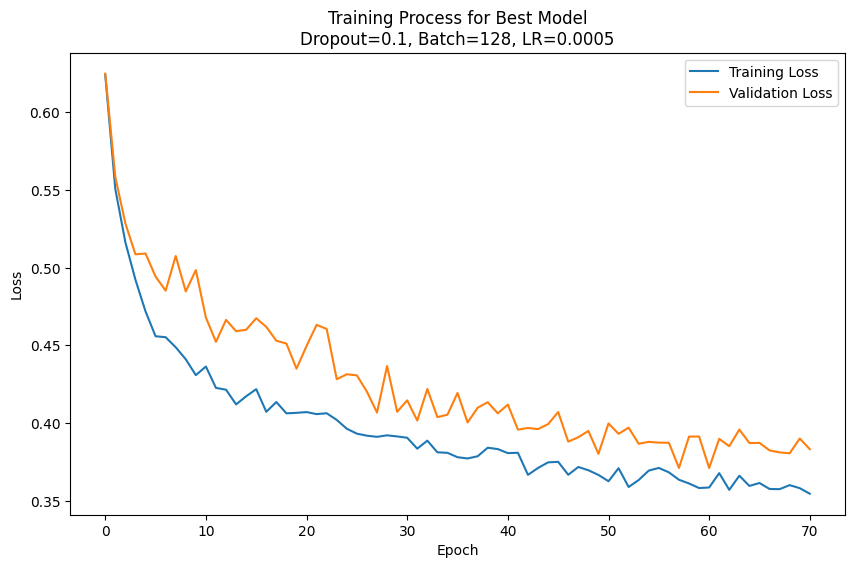

In [9]:
# Сначала посмотрим структуру результатов для одного эксперимента
for exp in results:
    print(f"\nЭксперимент:")
    print(f"Version: {exp['version']}")
    print(f"Dropout Rate: {exp['dropout_rate']}")
    print(f"Batch Size: {exp['batch_size']}")
    print(f"Learning Rate: {exp['lr']}")
    print("Test Performance:")
    print(exp['test_performance'])
    
    # Извлекаем accuracy из отчета
    accuracy = float(exp['test_performance'].split('\n')[3].split()[-2])
    print(f"Accuracy: {accuracy}")

# Теперь найдем лучший эксперимент по accuracy
best_experiment = max(results, 
                     key=lambda x: float(x['test_performance'].split('\n')[3].split()[-2]))

print("\nЛучшая конфигурация:")
print(f"Version: {best_experiment['version']}")
print(f"Dropout Rate: {best_experiment['dropout_rate']}")
print(f"Batch Size: {best_experiment['batch_size']}")
print(f"Learning Rate: {best_experiment['lr']}")
print("\nTest Performance:")
print(best_experiment['test_performance'])

# Визуализируем процесс обучения для лучшей модели
plt.figure(figsize=(10, 6))
plt.plot(best_experiment['train_losses'], label='Training Loss')
plt.plot(best_experiment['val_losses'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title(f'Training Process for Best Model\nDropout={best_experiment["dropout_rate"]}, Batch={best_experiment["batch_size"]}, LR={best_experiment["lr"]}')
plt.legend()
plt.show()

### Вывод

- После усложнения архитектуры произошло улучшение качества. 

Лучший эксперимент с параметрами: 
Dropout Rate: 0.1
Batch Size: 128
Learning Rate: 0.0005

accuracy=0.83

#### 6.2 Попытка еще улучшить качество модели

#### Вариант 1: добавление батчнорма перед последним слоем без дропаута

Epoch 10/150:
Training Loss: 0.4059
Validation Loss: 0.4301
Epoch 20/150:
Training Loss: 0.3835
Validation Loss: 0.5399
Epoch 30/150:
Training Loss: 0.3607
Validation Loss: 0.3896
Epoch 40/150:
Training Loss: 0.3604
Validation Loss: 0.3929
Epoch 50/150:
Training Loss: 0.3416
Validation Loss: 0.3759
Epoch 60/150:
Training Loss: 0.3475
Validation Loss: 0.4483
Epoch 70/150:
Training Loss: 0.3470
Validation Loss: 0.3636
Epoch 80/150:
Training Loss: 0.3355
Validation Loss: 0.3600
Epoch 90/150:
Training Loss: 0.3371
Validation Loss: 0.3953
Epoch 100/150:
Training Loss: 0.3262
Validation Loss: 0.3659
Epoch 110/150:
Training Loss: 0.3280
Validation Loss: 0.3549
Epoch 120/150:
Training Loss: 0.3252
Validation Loss: 0.3581
Epoch 130/150:
Training Loss: 0.3294
Validation Loss: 0.3637
Epoch 140/150:
Training Loss: 0.3207
Validation Loss: 0.3515
Epoch 150/150:
Training Loss: 0.3193
Validation Loss: 0.3425


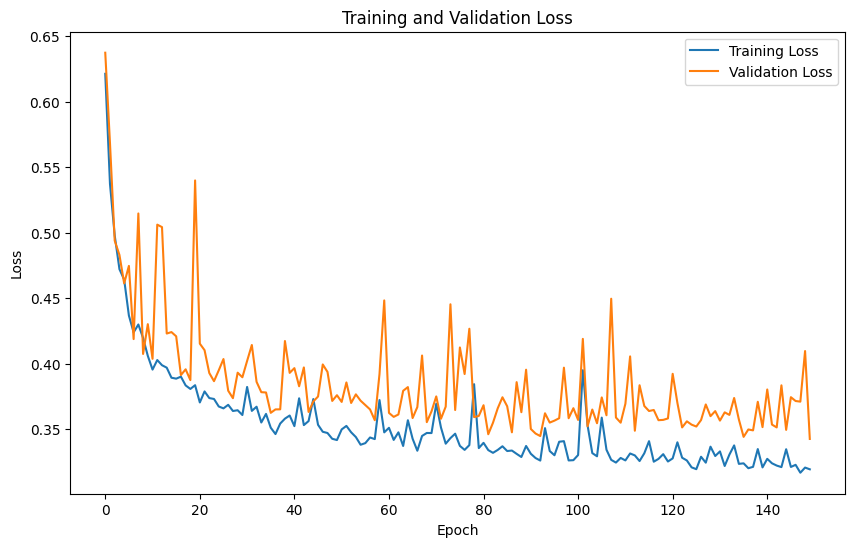


Test Set Performance:
              precision    recall  f1-score   support

         0.0       0.80      0.90      0.85       981
         1.0       0.89      0.79      0.84      1019

    accuracy                           0.84      2000
   macro avg       0.85      0.84      0.84      2000
weighted avg       0.85      0.84      0.84      2000



In [10]:
class ImprovedMLP(nn.Module):
    def __init__(self, input_size):
        super(ImprovedMLP, self).__init__()
        self.layers = nn.Sequential(
            # Сохраняем точно такую же архитектуру как в базовой модели
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            # Добавляем BatchNorm только перед последним слоем
            nn.BatchNorm1d(32),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.layers(x)

# Создание модели
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = ImprovedMLP(input_size=X_train.shape[1]).to(device)

# Точно те же параметры обучения, как в базовой модели
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()
n_epochs = 150

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Списки для хранения истории обучения
train_losses = []
val_losses = []
best_val_loss = float('inf')
best_model_state = None

# Цикл обучения
for epoch in range(n_epochs):
    train_loss = train_loop(model, train_loader, criterion, optimizer)
    val_loss = eval_loop(model, val_loader, criterion)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = model.state_dict().copy()
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch {epoch+1}/{n_epochs}:')
        print(f'Training Loss: {train_loss:.4f}')
        print(f'Validation Loss: {val_loss:.4f}')

# Загружаем лучшую модель
model.load_state_dict(best_model_state)

# Визуализация процесса обучения
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Оценка на тестовой выборке
print("\nTest Set Performance:")
print(evaluate_model(model, test_loader))



#### Вариант 2: более сложная архитектура без батчнорма и дропаута

Epoch 10/200:
Training Loss: 0.4442
Validation Loss: 0.5445
Epoch 20/200:
Training Loss: 0.4065
Validation Loss: 0.4470
Epoch 30/200:
Training Loss: 0.3900
Validation Loss: 0.4348
Epoch 40/200:
Training Loss: 0.3675
Validation Loss: 0.4464
Epoch 50/200:
Training Loss: 0.3656
Validation Loss: 0.4755
Early stopping at epoch 58


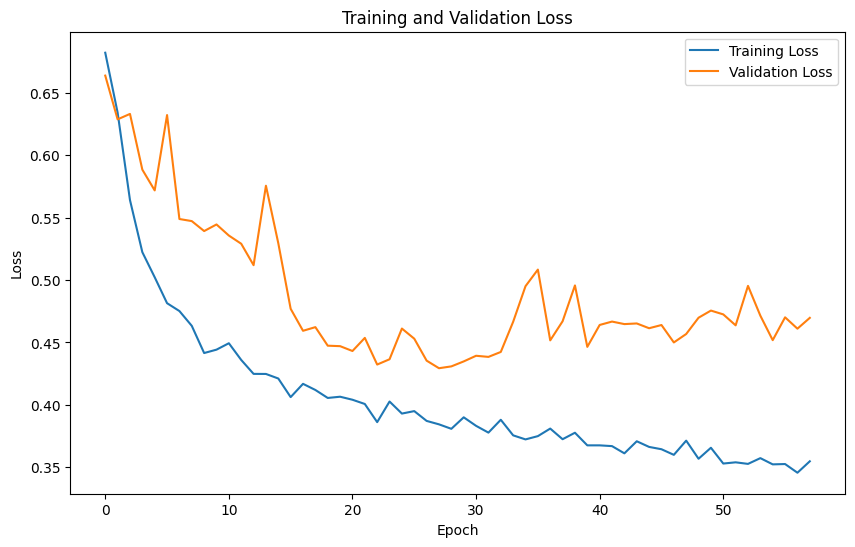


Test Set Performance:
              precision    recall  f1-score   support

         0.0       0.78      0.88      0.83       981
         1.0       0.87      0.76      0.81      1019

    accuracy                           0.82      2000
   macro avg       0.83      0.82      0.82      2000
weighted avg       0.83      0.82      0.82      2000



In [11]:
class ImprovedMLP(nn.Module):
    def __init__(self, input_size):
        super(ImprovedMLP, self).__init__()
        self.layers = nn.Sequential(
            # Начинаем с большей размерности
            nn.Linear(input_size, 256),
            nn.ReLU(),
            
            # Постепенно уменьшаем размерность
            nn.Linear(256, 128),
            nn.ReLU(),
            
            nn.Linear(128, 96),
            nn.ReLU(),
            
            nn.Linear(96, 64),
            nn.ReLU(),
            
            nn.Linear(64, 48),
            nn.ReLU(),
            
            nn.Linear(48, 32),
            nn.ReLU(),
            
            nn.Linear(32, 16),
            nn.ReLU(),
            
            # Выходной слой
            nn.Linear(16, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        return self.layers(x)

# Создание модели
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = ImprovedMLP(input_size=X_train.shape[1]).to(device)

# Настройка обучения - уменьшим learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)  # уменьшенный learning rate
criterion = nn.BCELoss()
n_epochs = 200

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Списки для хранения истории обучения
train_losses = []
val_losses = []
best_val_loss = float('inf')
best_model_state = None
patience = 30  # увеличим patience еще больше
counter = 0

# Цикл обучения
for epoch in range(n_epochs):
    train_loss = train_loop(model, train_loader, criterion, optimizer)
    val_loss = eval_loop(model, val_loader, criterion)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = model.state_dict().copy()
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print(f'Early stopping at epoch {epoch+1}')
            break
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch {epoch+1}/{n_epochs}:')
        print(f'Training Loss: {train_loss:.4f}')
        print(f'Validation Loss: {val_loss:.4f}')

# Загружаем лучшую модель
model.load_state_dict(best_model_state)

# Визуализация
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Оценка на тестовой выборке
print("\nTest Set Performance:")
print(evaluate_model(model, test_loader))

#### Вариант 3: добавление только дропаута

Epoch 10/200:
Training Loss: 0.4158
Validation Loss: 0.3888
Epoch 20/200:
Training Loss: 0.3830
Validation Loss: 0.3735
Epoch 30/200:
Training Loss: 0.3852
Validation Loss: 0.3881
Epoch 40/200:
Training Loss: 0.3625
Validation Loss: 0.4615
Epoch 50/200:
Training Loss: 0.3465
Validation Loss: 0.4465
Epoch 60/200:
Training Loss: 0.3516
Validation Loss: 0.5169
Epoch 70/200:
Training Loss: 0.3405
Validation Loss: 0.4499
Early stopping at epoch 74


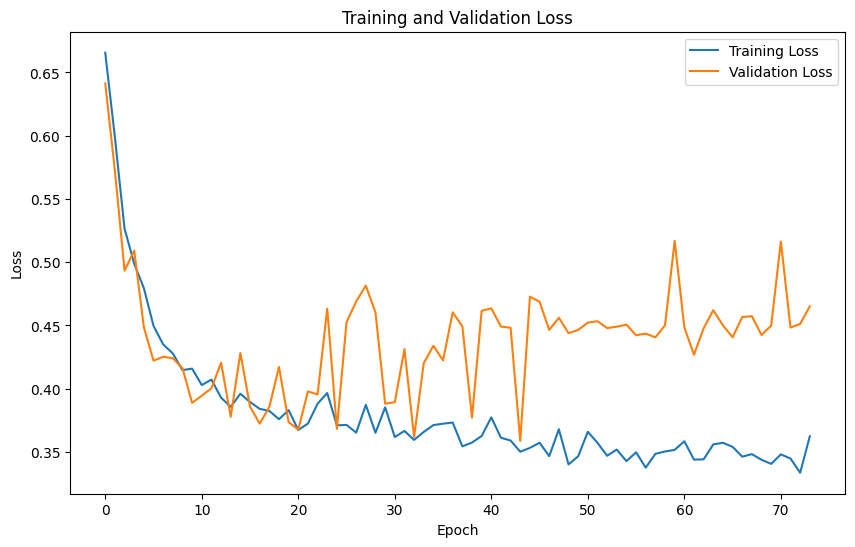


Test Set Performance:
              precision    recall  f1-score   support

         0.0       0.79      0.88      0.83       981
         1.0       0.87      0.78      0.82      1019

    accuracy                           0.83      2000
   macro avg       0.83      0.83      0.83      2000
weighted avg       0.83      0.83      0.83      2000



In [12]:
class ImprovedMLP(nn.Module):
    def __init__(self, input_size):
        super(ImprovedMLP, self).__init__()
        self.layers = nn.Sequential(
            # Начальные слои с большим dropout
            nn.Linear(input_size, 256),
            nn.ReLU(),
            nn.Dropout(0.1),  # Больший dropout в начале
            
            nn.Linear(256, 192),  # Добавили дополнительный слой
            nn.ReLU(),
            nn.Dropout(0.1),
            
            nn.Linear(192, 128),
            nn.ReLU(),
            nn.Dropout(0.07),  # Уменьшаем dropout
            
            nn.Linear(128, 96),
            nn.ReLU(),
            nn.Dropout(0.05),
            
            nn.Linear(96, 64),
            nn.ReLU(),
            nn.Dropout(0.03),  # Совсем небольшой dropout
            
            nn.Linear(64, 48),
            nn.ReLU(),
            
            nn.Linear(48, 32),
            nn.ReLU(),
            
            nn.Linear(32, 16),
            nn.ReLU(),
            
            # Выходной слой
            nn.Linear(16, 1),
            nn.Sigmoid()
        )
        
        # Инициализация весов Xavier/Glorot
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        return self.layers(x)

# Создание модели
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = ImprovedMLP(input_size=X_train.shape[1]).to(device)

# Настройка обучения
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-6)  # добавили очень легкий weight decay
criterion = nn.BCELoss()
n_epochs = 200

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Списки для хранения истории обучения
train_losses = []
val_losses = []
best_val_loss = float('inf')
best_model_state = None
patience = 30  # увеличили patience
counter = 0

# Цикл обучения
for epoch in range(n_epochs):
    train_loss = train_loop(model, train_loader, criterion, optimizer)
    val_loss = eval_loop(model, val_loader, criterion)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = model.state_dict().copy()
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print(f'Early stopping at epoch {epoch+1}')
            break
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch {epoch+1}/{n_epochs}:')
        print(f'Training Loss: {train_loss:.4f}')
        print(f'Validation Loss: {val_loss:.4f}')

# Загружаем лучшую модель
model.load_state_dict(best_model_state)

# Визуализация
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Оценка на тестовой выборке
print("\nTest Set Performance:")
print(evaluate_model(model, test_loader))

### Выводы по улучшению модели:

1. Лучше всего показывает себя вариант с добавлением батчнорма перед последним слоем без дропаута.
2. Пробовал варианты с увеличение количества эпох до 200 и более сложные модификации (дополнительные слои, dropout, residual connections) - не привели к улучшению качества